Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph

categories:[multimodal learning, deep learning, Transformer, Graph]

Motivation
In the article 'Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph', the MMFDL model is used for predicting drug properties. We tested the model using six single-molecule datasets, including Delaney, Llinas2020, Lipophilicity, SAMPL, BACE and pKa from DataWarrior. 
In this post, we use the SAMPL dataset for how to train MMFDL model. The input of the model is to convert drug molecules into three molecular representations: SMILES-encoed vectors、ECFP fingerprints and molecular graphs. To process the modal nformation, Transformer-Ecoder、BiGRU and graph convolutional network(GCN) are utilized for feature learning respectively. Then this model uses five fusion methods to capture specific features.

I'll use SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset fro protein and ligand modeling and consists of 642 experimental values logP.

Let's take the SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset for protein and ligand modeling and consists of 642 experimental values logP.

MMFDL_singleBiGRU.ipynb is a single BiGRU model.

Prepare training data and testing data.

In [1]:
# from myTrCPI.script.makeModel.utils_smiecfp import *
from sklearn import metrics
# from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import InMemoryDataset, DataLoader
# from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import warnings
import pickle
import sys
sys.path.append('../util')
from utils_smiecfp import *
from data_gen_modify import *
from analysis import *
from utils import *

sys.path.append('../model')
from model_trans_bigru_gcn import modelBigru_ep


gpu_index = 0  # 可以根据需要更改为其他 GPU 编号

# 检查是否有可用的 GPU 设备
if torch.cuda.is_available():
    # 设置为指定的 GPU 设备
    device = torch.device(f'cuda:{gpu_index}')
else:
    # 如果没有可用的 GPU，使用 CPU
    device = torch.device('cpu')


epochs = 50
batch_size = 16
label = 100
random_state = 42

argsLstm = {
    'n_output': 1,
    'num_features': 1024,
    'output_dim': 128,
    'dropout': 0.1, 
    'hidden_dim_lstm': 256
}



resultLoss = {'losses_train': [], 'losses_val': []}

train_data = formDataset(root='../dataSour', dataset='data_train')
train_ratio = 0.8
num_data = len(train_data)
indices = list(range(num_data))
train_indices, val_indices = train_test_split(indices, train_size=train_ratio, shuffle=True, random_state=random_state)
train_dataset = [train_data[i] for i in train_indices]
val_dataset = [train_data[i] for i in val_indices]
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_data = formDataset(root='../dataSour', dataset='data_test')
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Pre-processed data found: ../dataSour/processed/data_train.pt, loading ...
Pre-processed data found: ../dataSour/processed/data_test.pt, loading ...


/home/bioinfor3/.conda/envs/lxh-TransFM3/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


The input to BiGRU is ECFP fingerprint.

In [4]:
learning_rate = 0.0001
model = modelBigru_ep(argsLstm).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

model.train()
for i in range(epochs):
    print("Running EPOCH",i+1)
    total_loss = 0
    n_batches = 0
    correct = 0
    '''
        train部分
    '''
    for batch_idx, data in enumerate(trainLoader):
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = torch.FloatTensor(data.y).to(device)
        y_pred = model(ecfp) 
        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(), y.type(torch.DoubleTensor))
        total_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        n_batches+=1
    avg_loss = total_loss / n_batches
    resultLoss['losses_train'].append(avg_loss)
    print('train avg_loss is: ', avg_loss.item())

    '''
        val部分
    '''
    total_loss = 0
    n_batches = 0
    correct = 0
    for batch_idx, data in enumerate(valLoader):
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = torch.FloatTensor(data.y).to(device)
        y_pred = model(ecfp) 
        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(), y.type(torch.DoubleTensor))
        total_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        n_batches+=1
    avg_loss = total_loss / n_batches
    resultLoss['losses_val'].append(avg_loss) 
    print('val avg_loss is: ', avg_loss.item())
    print('\n')



y_pred_list = []
y_sour_list = []
correct = 0

model.eval()
for batch_idx, data in enumerate(testLoader):
    ecfp = torch.FloatTensor(data.ep).to(device)
    y = torch.FloatTensor(data.y).to(device)
    y_pred = model(ecfp) 
    y_pred_list.append(y_pred.squeeze().tolist())
    y_sour_list.append(y.tolist())

y_pred = []
for data in y_pred_list:
    for item in data:
        value = round(item, 2)
        y_pred.append(value)

y = []
for data in y_sour_list:
    for item in data:
        value = round(item, 2)
        y.append(value)

yResult = {}
ground_truth = np.array(y)
predictions = np.array(y_pred)
# calculate rmse
squared_errors = (ground_truth - predictions) ** 2
rmse = np.sqrt(np.mean(squared_errors))
yResult['rmse'] = rmse
# calculate mae
absolute_errors = np.abs(ground_truth - predictions)
mae = np.mean(absolute_errors)
yResult['mae'] = mae
print(yResult)

Running EPOCH 1


train avg_loss is:  29.828204896650796
val avg_loss is:  23.439291578448678


Running EPOCH 2
train avg_loss is:  29.652462350933547
val avg_loss is:  20.092212515233236


Running EPOCH 3
train avg_loss is:  24.74589373122268
val avg_loss is:  18.307874868761406


Running EPOCH 4
train avg_loss is:  23.96273193620623
val avg_loss is:  16.66790390127043


Running EPOCH 5
train avg_loss is:  22.10464637177545
val avg_loss is:  16.347558781062137


Running EPOCH 6
train avg_loss is:  20.427800180976988
val avg_loss is:  14.772892911202023


Running EPOCH 7
train avg_loss is:  19.54555046985536
val avg_loss is:  14.072890797352702


Running EPOCH 8
train avg_loss is:  18.935107334947244
val avg_loss is:  13.470514301768706


Running EPOCH 9
train avg_loss is:  18.132513595280763
val avg_loss is:  12.640663373160026


Running EPOCH 10
train avg_loss is:  17.20772691322468
val avg_loss is:  12.038096979030005


Running EPOCH 11
train avg_loss is:  16.938390494342052
val avg_loss is:  12.3003

Save results

pearson:  (0.7267131069836577, 3.518279514306335e-16)
0.43227957554803387 0.7267131069836582


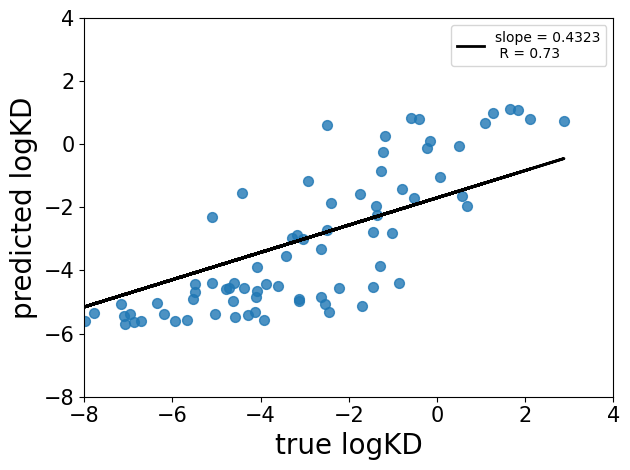



../result/100-result-16-50-42-lstm(ep).csv	saved successfully


: 

In [5]:
savePath = '../result/{}_rmseMae_{}_{}_{}_lstm(ep).csv'.format(label, batch_size, epochs, random_state)
rmseAndMae(yResult, savePath)


savePath = '../result/{}_scatter_predited_{}_{}_{}_lstm(ep).png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(y_pred, y, savePath)
print('\n')

result = {}
result['y_pred'] = y_pred
result['y'] = y
resultPath = '../result/{}-result-{}-{}-{}-lstm(ep).csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')

savePath = '../result/{}_loss_{}_{}_{}_lstm(ep).png'.format(label, batch_size, epochs, random_state)

savePath = '../result/{}_loss_{}_{}_{}_lstm(ep).csv'.format(label, batch_size, epochs, random_state)
lossDf = pd.DataFrame(resultLoss)
lossDf.to_csv(savePath, index=False)